In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import itertools
from PIL import Image, ImageChops, ImageEnhance
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png'

    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image

In [3]:
image_size = (128, 128)
def prepare_image(image_path):
    return np.array(convert_to_ela_image(image_path, 90).resize(image_size)).flatten() / 255.0

In [4]:
X = [] # ELA converted images
Y = [] # 0 for forged, 1 for authentic

In [5]:
# Load authentic images
path = 'dataset/authentic'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)

In [6]:
# Load forged images
path = 'dataset/forged'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)

In [7]:
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)


In [9]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [10]:
base_model_mobilenet = MobileNetV2(input_shape=(128, 128, 3),
                                   include_top=False, weights='imagenet')

for layer in base_model_mobilenet.layers:
    layer.trainable = False

x_mobilenet = layers.Flatten()(base_model_mobilenet.output)
x_mobilenet = layers.Dense(1024, activation='relu')(x_mobilenet)
x_mobilenet = layers.Dropout(0.2)(x_mobilenet)
x_mobilenet = layers.Dense(2, activation='softmax')(x_mobilenet)

model_mobilenet = tf.keras.models.Model(base_model_mobilenet.input, x_mobilenet)

model_mobilenet.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

mc_mobilenet = tf.keras.callbacks.ModelCheckpoint(filepath="./mobilenet_best_model.keras",
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode='auto')

mobilenet_callbacks = [mc_mobilenet]

mobilenet_history = model_mobilenet.fit(X_train, Y_train,
                                        epochs=32,
                                        validation_data=(X_val, Y_val),
                                        callbacks=mobilenet_callbacks)

model_mobilenet.save('model_mobilenet.keras')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7522 - loss: 1.7353
Epoch 1: val_accuracy improved from -inf to 0.88750, saving model to ./mobilenet_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 0.7532 - loss: 1.7219 - val_accuracy: 0.8875 - val_loss: 0.2817
Epoch 2/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9029 - loss: 0.2828
Epoch 2: val_accuracy did not improve from 0.88750
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9025 - loss: 0.2837 - val_accuracy: 0.8400 - val_loss: 0.5747
Epoch 3/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.9383 - loss: 0.1998
Epoch 3: val_accuracy improved from 0.88750 to 0.91750, saving model to ./mobilenet_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.9381 - loss: 0.2003 - val_accuracy: 0.9175 - val_loss: 0.2391
Epoch 4/32
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.9457 - loss: 0.1640
Epoch

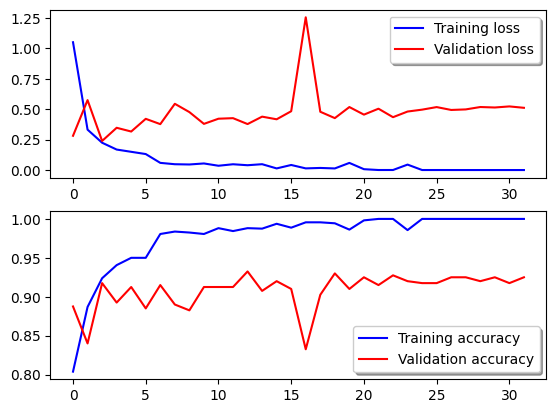

In [11]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(mobilenet_history.history['loss'], color='b', label="Training loss")
ax[0].plot(mobilenet_history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(mobilenet_history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(mobilenet_history.history['val_accuracy'], color='r', label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

plt.show()

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step


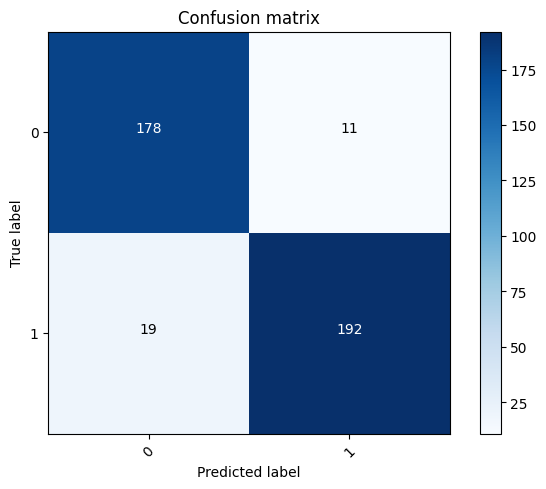

In [12]:
Y_pred_vgg = model_mobilenet.predict(X_val)
Y_pred_classes_vgg = np.argmax(Y_pred_vgg, axis=1)
Y_true_vgg = np.argmax(Y_val, axis=1)
confusion_mtx_vgg = confusion_matrix(Y_true_vgg, Y_pred_classes_vgg)

plot_confusion_matrix(confusion_mtx_vgg, classes=range(2))

In [13]:
print("Classification report for MobileNetV2:")
print(classification_report(Y_true_vgg, Y_pred_classes_vgg, target_names=['forged', 'authentic']))
accuracy_vgg = accuracy_score(Y_true_vgg, Y_pred_classes_vgg)
print("Overall accuracy for MobileNetV2: {:.2f}%".format(accuracy_vgg*100))

Classification report for VGG16:
              precision    recall  f1-score   support

      forged       0.90      0.94      0.92       189
   authentic       0.95      0.91      0.93       211

    accuracy                           0.93       400
   macro avg       0.92      0.93      0.92       400
weighted avg       0.93      0.93      0.93       400

Overall accuracy for VGG16: 92.50%


In [14]:
sample_paths = [
    'dataset/authentic/33.jpg',
    'dataset/authentic/34.jpg',
    'dataset/authentic/35.jpg',
    'dataset/authentic/335.jpg',
    'dataset/authentic/336.jpg',
    'dataset/authentic/337.jpg',
    'dataset/authentic/338.jpg',
    'dataset/authentic/339.jpg',
    'dataset/forged/1257_1258.png',
    'dataset/forged/1259_1260.png',
    'dataset/forged/1261_1262.png',
    'dataset/forged/1262_1263.png',
    'dataset/forged/1265_1266.png',
    'dataset/forged/1266_1267.png',
    'dataset/forged/1269_1270.png',
    'dataset/forged/1271_1272.png',
    'dataset/forged/1273_1274.png',
    'dataset/forged/1276_1277.png',
]

In [15]:
for sample_path in sample_paths:
    image = prepare_image(sample_path)
    image = image.reshape(-1, 128, 128, 3)
    y_pred = model_mobilenet.predict(image)
    y_pred_class = np.argmax(y_pred, axis = 1)[0]
    class_names = ['forged', 'authentic']
    print(f'Image: {sample_path}, Predicted class: {class_names[y_pred_class]}, Confidence: {np.amax(y_pred) * 100:0.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Image: dataset/authentic/33.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: dataset/authentic/34.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: dataset/authentic/35.jpg, Predicted class: authentic, Confidence: 99.98%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Image: dataset/authentic/335.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Image: dataset/authentic/336.jpg, Predicted class: authentic, Confidence: 99.99%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: dataset/authentic/337.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: dataset/authentic/338.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: dataset/authentic/339.jpg, Predicted class: authentic, Confidence: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Image: 

In [16]:
correct = 0
total = 0

for dirname, _, filenames in os.walk('dataset/forged'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_mobilenet.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 0:
                correct += 1

for dirname, _, filenames in os.walk('dataset/authentic'):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            image_path = os.path.join(dirname, filename)
            image = prepare_image(image_path)
            image = image.reshape(-1, 128, 128, 3)
            y_pred = model_mobilenet.predict(image)
            y_pred_class = np.argmax(y_pred, axis = 1)[0]
            total += 1
            if y_pred_class == 1:
                correct += 1

print(f'Total: {total}, Correct: {correct}, Accuracy: {correct / total * 100.0:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━